## Data Scientist Presentation

#### Dylan Chou

## Problem Statement

You have been given two datasets. One dataset includes application data for every customer that has been given a loan in a 6 month period. The other contains every loan that has been given in this time and whether it has been a good loan or a bad loan. Use the data to identify which new applicants should be given a loan in the future. Discuss any problems or limitations with the data, shortcomings of the analysis and/or additional data elements that might be useful. You should present your findings in a presentation lasting less than 30 minutes including time for questions.

#### External Dataset
* Zillow Home Value Index by State:
  * Kaggle Link: https://www.kaggle.com/datasets/robikscube/zillow-home-value-index
* US Zip Code to State
  * Kaggle Link: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset
* US State to Region
  * Kaggle Link: https://www.kaggle.com/datasets/omer2040/usa-states-to-region

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 10.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency
import scipy.stats as stats
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.linear_model import Lasso
from sklearn.calibration import calibration_curve

from collections import defaultdict
from functools import reduce
import shap

In [ ]:
customer_df = pd.read_excel("Homework - Data Scientist.xlsx",
                sheet_name="Application Data")
loan_perf_df = pd.read_excel("Homework - Data Scientist.xlsx",
                sheet_name="Loan Performance")

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
zhvi_df = pd.read_csv("ZHVI.csv", index_col=0)

In [ ]:
zip_to_state = pd.read_csv("realtor-zip.csv")[["state", "zip_code"]]\
                 .rename(columns={"zip_code": "address_zip"})


In [ ]:
state_to_region = pd.read_csv("states.csv")
state_to_region = state_to_region.rename(columns={"State": "state",
                                "Region": 'region',
                                "Division": "division"})

In [ ]:
zip_to_state_mapping = zip_to_state.set_index("address_zip").to_dict()["state"]
zip_to_state_map = {84110: "Utah",
                    57339: "South Dakota",
                    84053: "Utah",
                    57709: "South Dakota",
                    57311: "South Dakota",
                    83636: "Idaho"}

zip_to_state_mapping = zip_to_state_mapping | zip_to_state_map

In [ ]:
customer_df["state"] = customer_df["address_zip"]\
                               .map(lambda x: zip_to_state_mapping[x])

## Feature Engineering/EDA

#### Summary of Approved Loans

* 647 Approved Loans
* 30 Features, 1 customer ID column
* **Significant missingness for other_phone_type (44% missing)**

In [ ]:
nrows, ncols = customer_df.shape
print(f"Number of observations: {nrows}, Number of columns: {ncols}")
display_df = customer_df.isna().sum(axis=0)
display_df = display_df[display_df > 0]
display_df.name = "Number of Missing Values"
proportion_missingness = round(customer_df.isna().mean(axis=0), 4)
proportion_missingness.name = "Proportion Missing (%)"
pd.concat([display_df,(100*proportion_missingness[proportion_missingness > 0]).astype(str) +"%" ],
          axis=1)

Number of observations: 647, Number of columns: 32


Number of Missing Values Proportion Missing (%)
payment_amount_approved                        20                  3.09%
bank_account_duration                           1                  0.15%
other_phone_type                              285                 44.05%
how_use_money                                   2                  0.31%

#### Summary of Loan Performance
* A loan id along with a flag indicating whether the loan performance was good or bad.
* No missing values.

In [ ]:
loan_perf_df.isna().sum(axis=0).rename("Number of Missing Values")

idLoan     0
flgGood    0
Name: Number of Missing Values, dtype: int64

In [ ]:
zhvi_melted = pd.melt(zhvi_df.reset_index(drop=False, names=["date"]),
        id_vars=["date"],
        var_name="State", value_name="ZHVI")

In [ ]:
multi_loans = pd.DataFrame(loan_perf_df["idLoan"].str.lower().str.split("-").to_list(),
                           columns=["idLoan", "version"])
loan_perf_df = pd.concat([multi_loans, loan_perf_df[["flgGood"]]], axis=1)\
          .sort_values(by=["version"],ascending=False)\
          .drop_duplicates(subset=["idLoan"], keep="first")

#### Removed Data
* 13 customers that did not correspond with a flagged loan: 634 customers remaining
* Removal of Monthly Rent Amount column containing 100/634 ~ 16% 0 monthly rent amounts. Also, monthly rent amount distribution does not differ between the good and bad loans.

In [ ]:
loan_df = customer_df.merge(loan_perf_df,
                  left_on="customer_id",
                  right_on="idLoan",
                  how="left")

In [ ]:
loan_df = loan_df[~loan_df["flgGood"].isna()]

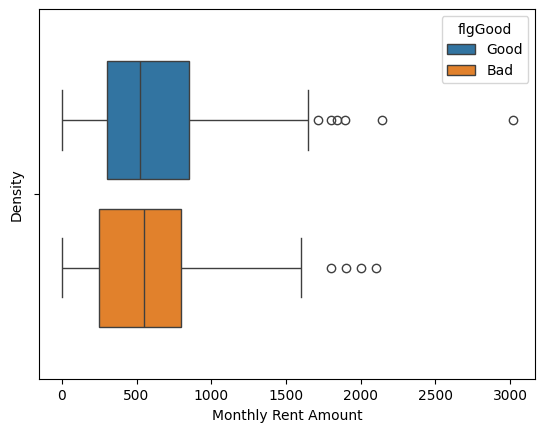

In [ ]:
# overlapping monthly rent amount distributions
# against the target class
sns.boxplot(loan_df,
    x="monthly_rent_amount",
    hue="flgGood", gap=0.2,
)

plt.legend(title="flgGood", loc="upper right")
plt.xlabel("Monthly Rent Amount")
plt.ylabel("Density")
plt.show()

In [ ]:
monthly_rent_good = loan_df[loan_df["flgGood"] == "Good"]["monthly_rent_amount"]
monthly_rent_bad = loan_df[loan_df["flgGood"] == "Bad"]["monthly_rent_amount"]

stats.kstest(monthly_rent_good.dropna(), monthly_rent_bad.dropna())

KstestResult(statistic=0.05472160333894529, pvalue=0.7091164311197212, statistic_location=780, statistic_sign=-1)

At a 5% significance level, we would fail to reject the null hypothesis that there is not difference in the distribution of monthly rent amount between good and bad performing loans of the customers.

In [ ]:
loan_df = loan_df.drop(columns=["monthly_rent_amount"])

### Add or Remove Features/Modify Existing
* Remove uninformative features that lack diverse segmentation
  * `payment_ach` - all but one observation has the same value
  * `status` - all customers have had their loans approved.
* Modifying existing features:
  * Birth Date to Age
  * Routing Number to Bank Name and Location using https://bank.codes/us-routing-number-checker/
  * In loan performance tab, there are multiple loans that may be given to a customer in this 6 month period. We take the most recent loan's performance for simplicity.
  * **Aggregating Features** - some aggregations that are sensible:
    * Loan and Financial related ratios
      * Debt to Income Ratio (Monthly)
      * Loan Approval Ratio
      * Payment Approval Ratio
    * Geographical Feature
      * ZHVI in State
      * Region of customer

* Notes about Features:
  * One bank routing number, 12400, has fewer than the expected 9 digits, but zeros preceding the first digit do not match up with known routing numbers.

In [ ]:
loan_df["payment_ach"].value_counts()

payment_ach
True     633
False      1
Name: count, dtype: int64

In [ ]:
loan_df = loan_df.drop(columns=["payment_ach"])

In [ ]:
loan_df["dti_monthly"] = loan_df["amount_approved"]/loan_df["monthly_income_amount"]

loan_df["loan_approval_ratio"] = loan_df["amount_approved"]/loan_df["amount_requested"]
loan_df["payment_approval_ratio"] = loan_df["payment_amount_approved"]/loan_df["payment_amount"]


In [ ]:
fico_columns = ["raw_FICO_telecom",
         "raw_FICO_retail",
         "raw_FICO_bank_card",
         "raw_FICO_money"]

In [ ]:
fico_data_melted = loan_df.melt(id_vars=["flgGood"], value_vars=fico_columns,
                                var_name="FICO Category", value_name="FICO Score")

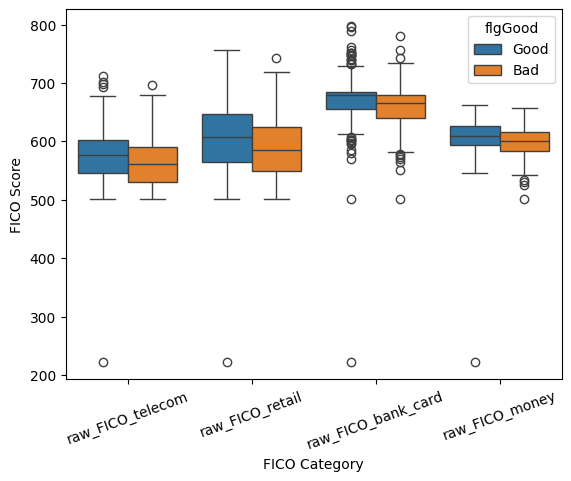

In [ ]:
sns.boxplot(x="FICO Category", y="FICO Score", hue="flgGood", data=fico_data_melted)
plt.xticks(rotation=20)
plt.show()

In [ ]:
loan_df[fico_columns].corr()

raw_FICO_telecom  raw_FICO_retail  raw_FICO_bank_card  \
raw_FICO_telecom            1.000000         0.895535            0.708659   
raw_FICO_retail             0.895535         1.000000            0.662097   
raw_FICO_bank_card          0.708659         0.662097            1.000000   
raw_FICO_money              0.759843         0.692350            0.675722   

                    raw_FICO_money  
raw_FICO_telecom          0.759843  
raw_FICO_retail           0.692350  
raw_FICO_bank_card        0.675722  
raw_FICO_money            1.000000

(array([0, 1, 2, 3]),
 [Text(0, 0, 'raw_FICO_telecom'),
  Text(0, 1, 'raw_FICO_retail'),
  Text(0, 2, 'raw_FICO_bank_card'),
  Text(0, 3, 'raw_FICO_money')])

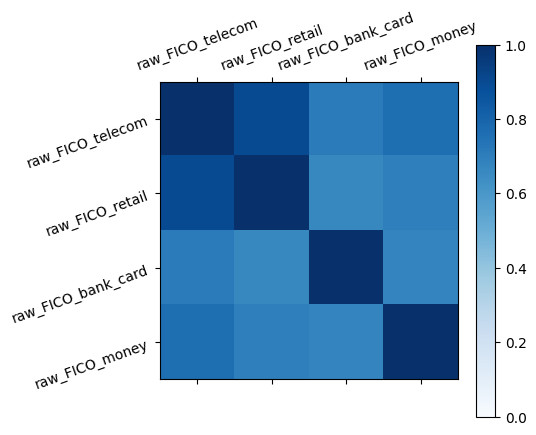

In [ ]:
plt.matshow(loan_df[fico_columns].corr(), cmap="Blues",
            norm=mcolors.Normalize(vmin=0, vmax=1))
plt.colorbar()
plt.xticks(range(len(fico_columns)), fico_columns)
plt.yticks(range(len(fico_columns)), fico_columns)
plt.xticks(rotation=20)
plt.yticks(rotation=20)

In [ ]:
# removal of payment approval ratios above 1
loan_df[loan_df["payment_approval_ratio"] > 1][["payment_amount", "payment_amount_approved", "payment_approval_ratio"]]

payment_amount  payment_amount_approved  payment_approval_ratio
333          115.88                    137.4                1.185709

In [ ]:
loan_df = loan_df[loan_df["payment_approval_ratio"] <= 1]

<Axes: xlabel='amount_approved', ylabel='count'>

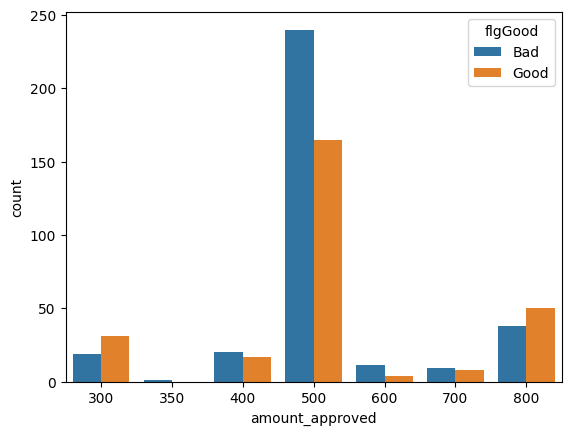

In [ ]:
sns.countplot(loan_df, x='amount_approved', hue='flgGood')

<Axes: xlabel='amount_requested', ylabel='count'>

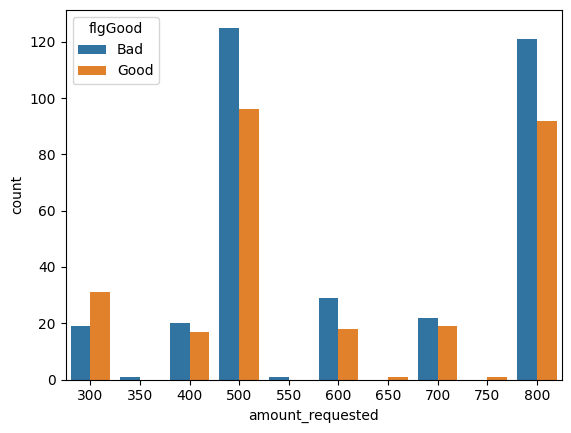

In [ ]:
sns.countplot(loan_df, x='amount_requested', hue='flgGood')

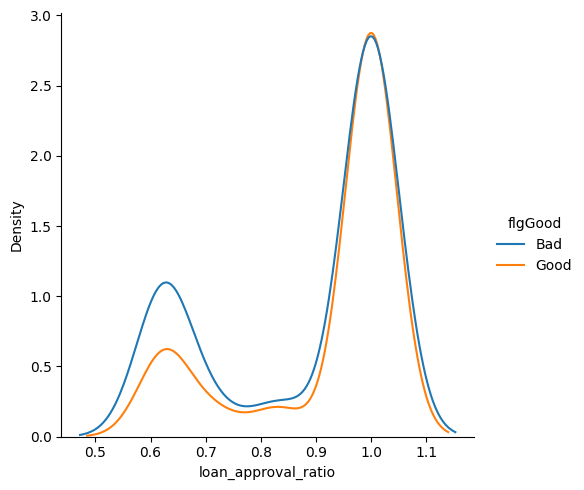

In [ ]:
sns.displot(loan_df, x="loan_approval_ratio", hue="flgGood",
            kind="kde")

<Axes: xlabel='payment_amount'>

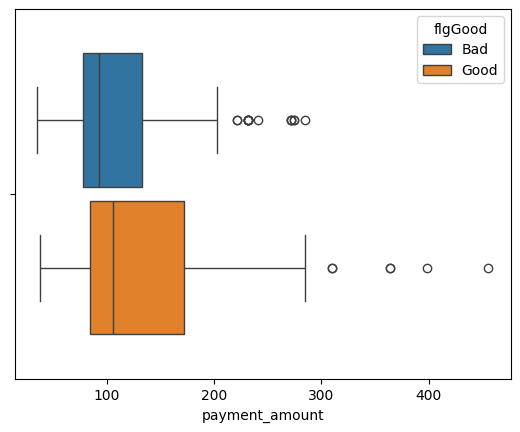

In [ ]:
sns.boxplot(data=loan_df, x='payment_amount', hue='flgGood',gap=.1)

<Axes: xlabel='payment_amount_approved'>

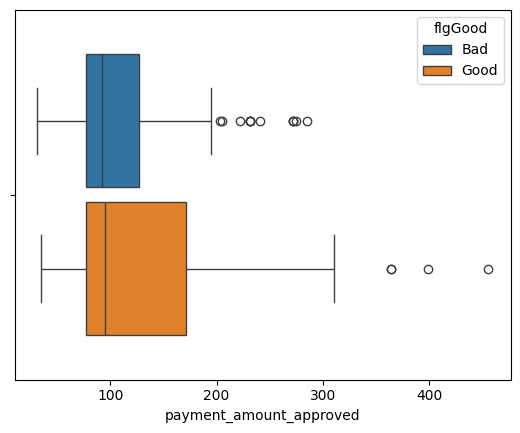

In [ ]:
sns.boxplot(data=loan_df, x='payment_amount_approved', hue='flgGood',gap=.1)

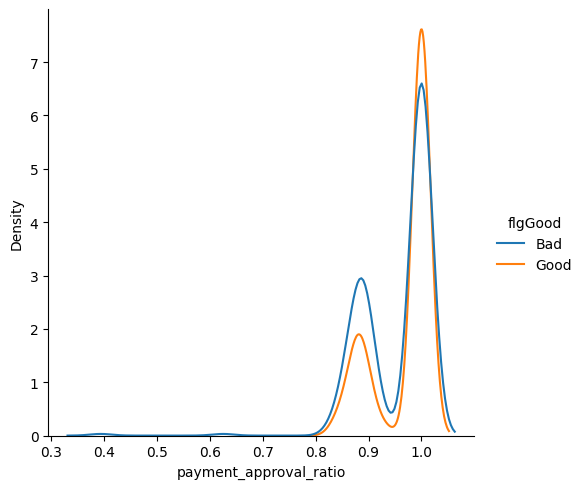

In [ ]:
sns.displot(loan_df, x="payment_approval_ratio", hue="flgGood",
            kind="kde")

<Axes: xlabel='amount_approved', ylabel='count'>

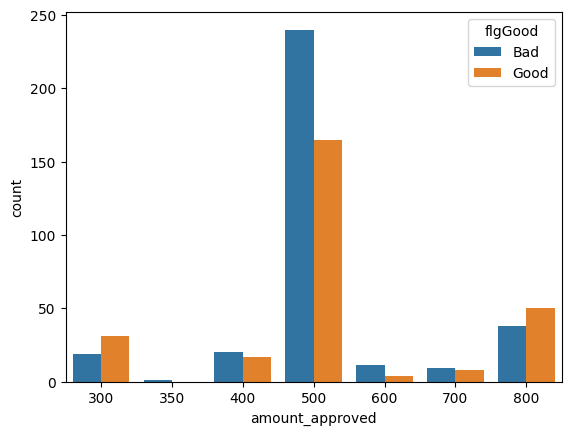

In [ ]:
sns.countplot(loan_df, x="amount_approved",
            hue="flgGood")

<Axes: xlabel='monthly_income_amount'>

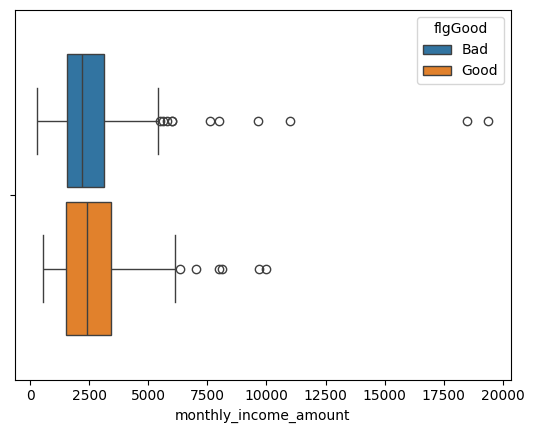

In [ ]:
sns.boxplot(data=loan_df, x='monthly_income_amount', hue='flgGood',gap=.1)

<Axes: xlabel='dti_monthly'>

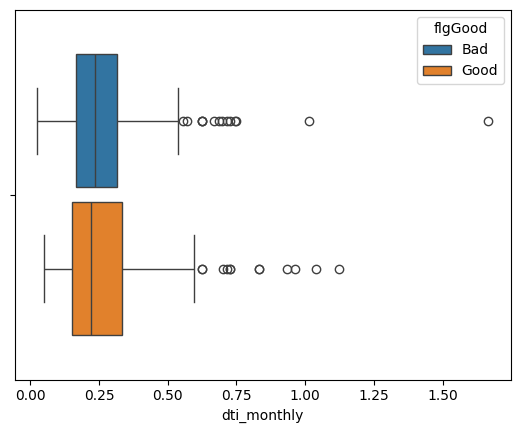

In [ ]:
sns.boxplot(data=loan_df, x='dti_monthly', hue='flgGood',gap=.1)

In [ ]:
loan_df["email_provider"] = loan_df['email'].str.split('@').str[1]
loan_df = loan_df.drop(columns=["email"])

In [ ]:
loan_df["age"] = (loan_df["application_when"] - loan_df["birth_date"]).apply(lambda x: x.days/365)

<Axes: xlabel='age'>

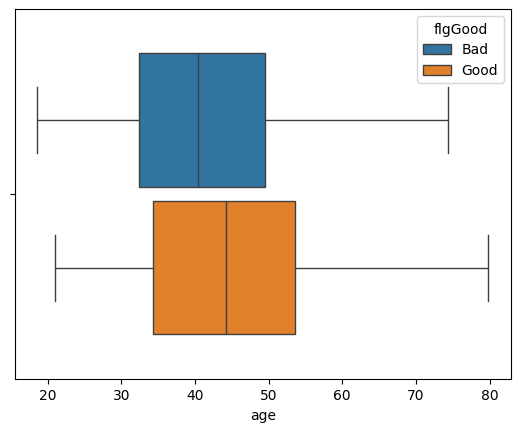

In [ ]:
sns.boxplot(data=loan_df, x='age', hue='flgGood', gap=.1)

In [ ]:
loan_df = loan_df.drop(columns=["birth_date"])

At a significance level of 5%, we fail to reject the null hypothesis that a customer's loan performance is independent of their "other" phone type. Due to high missingness, we remove the variable.

In [ ]:
other_phone_flag_tbl = loan_df[["other_phone_type", "flgGood"]].value_counts()\
          .reset_index(drop=False)\
          .pivot(index="other_phone_type", columns="flgGood")

chi2_contingency(other_phone_flag_tbl.values)

Chi2ContingencyResult(statistic=0.21166866688427055, pvalue=0.8995736650046495, dof=2, expected_freq=array([[ 35.14285714,  24.85714286],
       [ 44.51428571,  31.48571429],
       [125.34285714,  88.65714286]]))

In [ ]:
loan_df = loan_df.drop(columns=["other_phone_type"])

In [ ]:
loan_df = loan_df.drop(columns=["status"])

In [ ]:
payment_approved_good = loan_df[loan_df["flgGood"] == "Good"]["payment_amount_approved"]
payment_approved_bad = loan_df[loan_df["flgGood"] == "Bad"]["payment_amount_approved"]

In [ ]:
stats.kstest(payment_approved_good.dropna(), payment_approved_bad.dropna())

KstestResult(statistic=0.1625067240451856, pvalue=0.0005638011717687908, statistic_location=99.1, statistic_sign=-1)

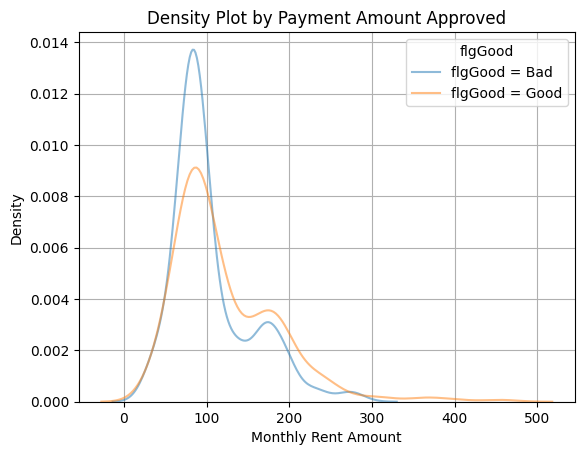

In [ ]:
for label in loan_df["flgGood"].unique():
    sns.kdeplot(
        data=loan_df[loan_df["flgGood"] == label],
        x="payment_amount_approved",
        label=f"flgGood = {label}",
        alpha=0.5
    )

plt.legend(title="flgGood", loc="upper right")
plt.title("Density Plot by Payment Amount Approved")
plt.xlabel("Monthly Rent Amount")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [ ]:
loan_df = loan_df[(~loan_df["bank_account_duration"].isna()) &\
        (~loan_df["how_use_money"].isna())]

In [ ]:
# drop based on low missingness
loan_df = loan_df[~loan_df["payment_approval_ratio"].isna()]

In [ ]:
zhvi_melted["date"] = zhvi_melted["date"].apply(lambda x:
                                                datetime.strptime(x, "%Y-%m-%d"))

In [ ]:
loan_df["application_when"] = loan_df["application_when"].dt.floor(freq="D")

In [ ]:
loan_df = pd.merge_asof(loan_df.sort_values("application_when").reset_index(drop=True),
              zhvi_melted.sort_values("date").reset_index(drop=True),
              left_on=["application_when"],
              right_on=["date"],
              left_by=["state"],
              right_by=["State"],
              direction="backward")

In [ ]:
loan_df = loan_df.drop(columns=["address_zip",
                                "bank_routing_number",
                                "version"])

In [ ]:
# get coarse geographical region from the zipcode -> state -> region as
# a categorical variable

loan_df = loan_df.merge(state_to_region,
              on=["state"],
              how="left")

In [ ]:
# region is a proxy for division
# 2 regions, 2 divisions
loan_df = loan_df.drop(columns=["division"])

Plots over categorical variables

In [ ]:
id_cols = ["customer_id", "idLoan"]
date_cols = ["application_when", "date"]
state_cols = ["state", "State", "State Code"]
y_col = "flgGood"
categorical_cols = ["how_use_money", "bank_account_duration",
                    "residence_duration",
                    "email_duration",
                    "residence_rent_or_own",
                    "email_provider",
                    "payment_frequency",
                    "home_phone_type",
                    "bank_account_direct_deposit",
                    "region"]
numerical_cols = loan_df.columns.drop(id_cols + date_cols +
                                      state_cols + [y_col] + categorical_cols)

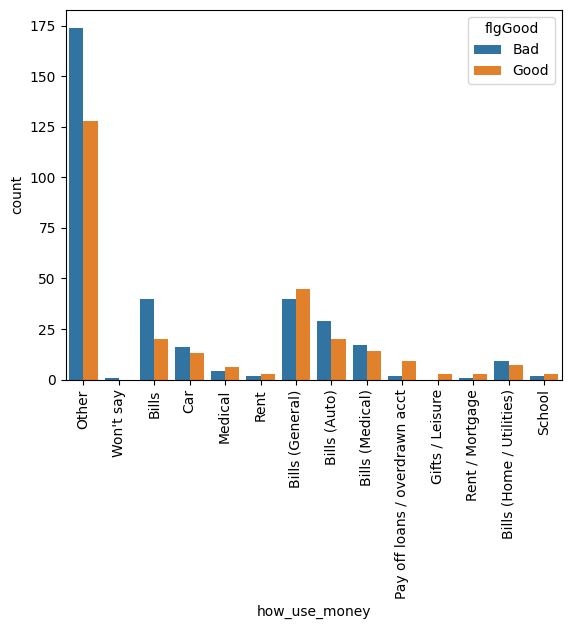

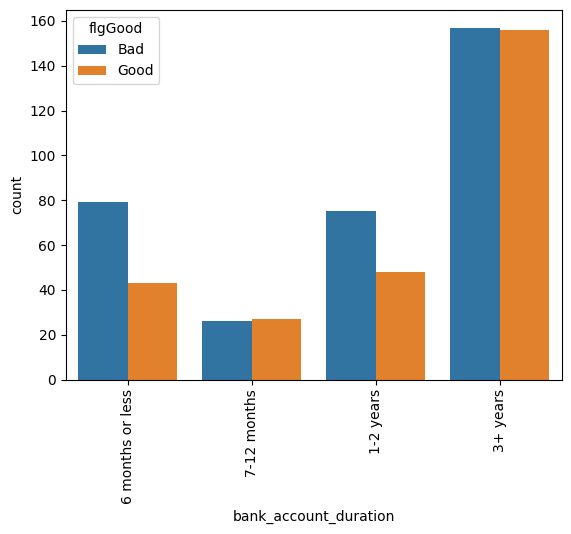

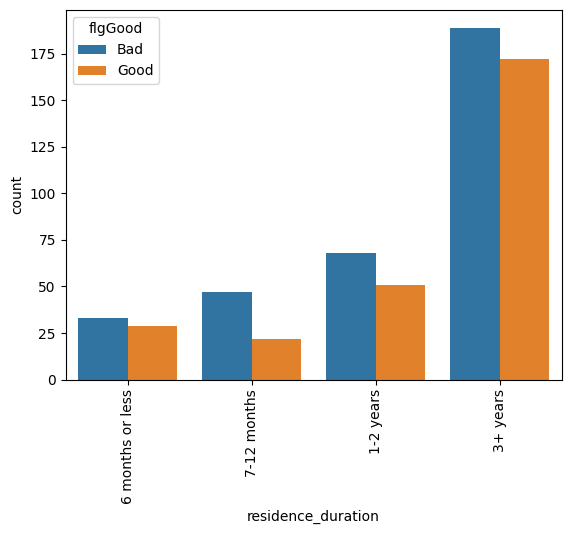

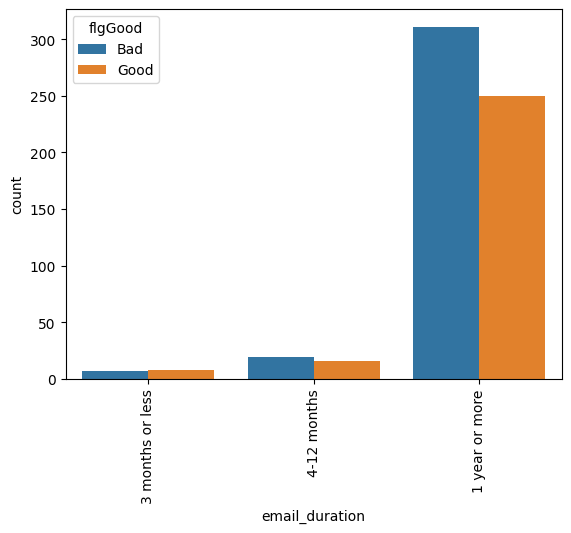

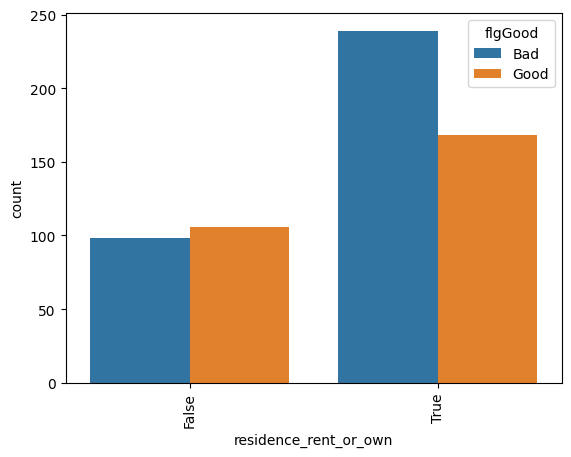

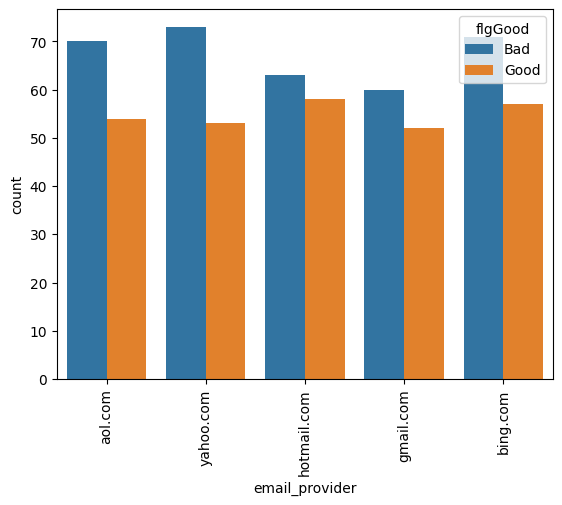

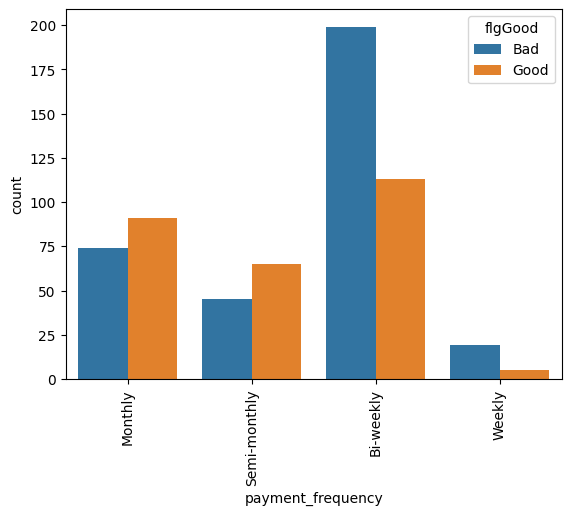

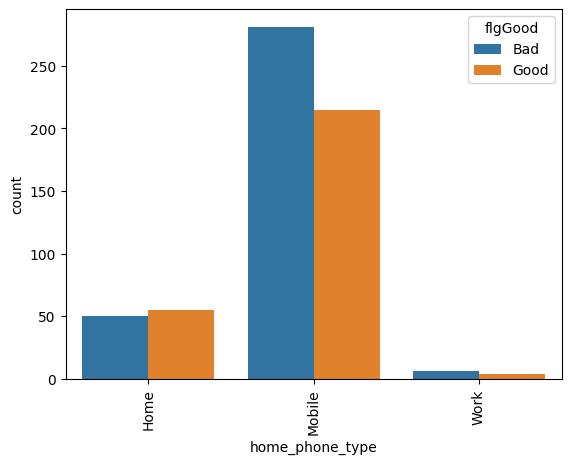

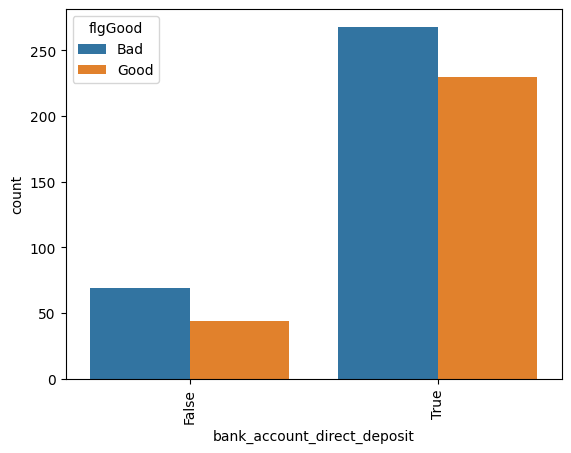

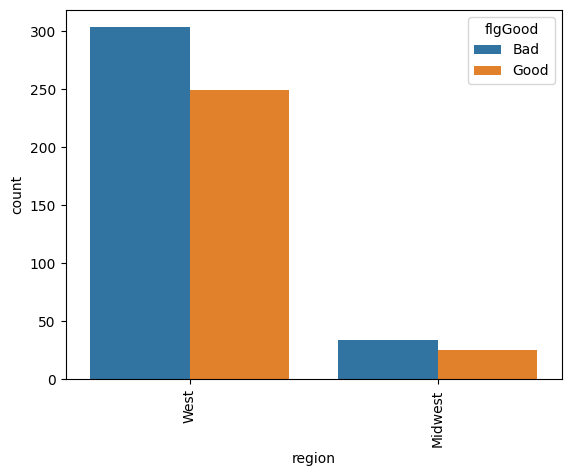

In [ ]:
for col in categorical_cols:
  if col in ["bank_account_duration","residence_duration"]:
    g = sns.countplot(loan_df, x=col, hue=y_col,
                      order=["6 months or less",
                             "7-12 months",
                             "1-2 years",
                             "3+ years"])
  elif col == "email_duration":
    g = sns.countplot(loan_df, x=col, hue=y_col,
                      order=["3 months or less",
                             "4-12 months",
                             "1 year or more"])
  else:
    g = sns.countplot(loan_df, x=col, hue=y_col)
  plt.xticks(rotation=90)
  plt.show()

Most customers with loan histories live in the West region, Mountain division of the US with a bank account direct deposit, a mobile home phone, bi-weekly loan payments, and a rent or owned property.

Correlation plot over numerical variables

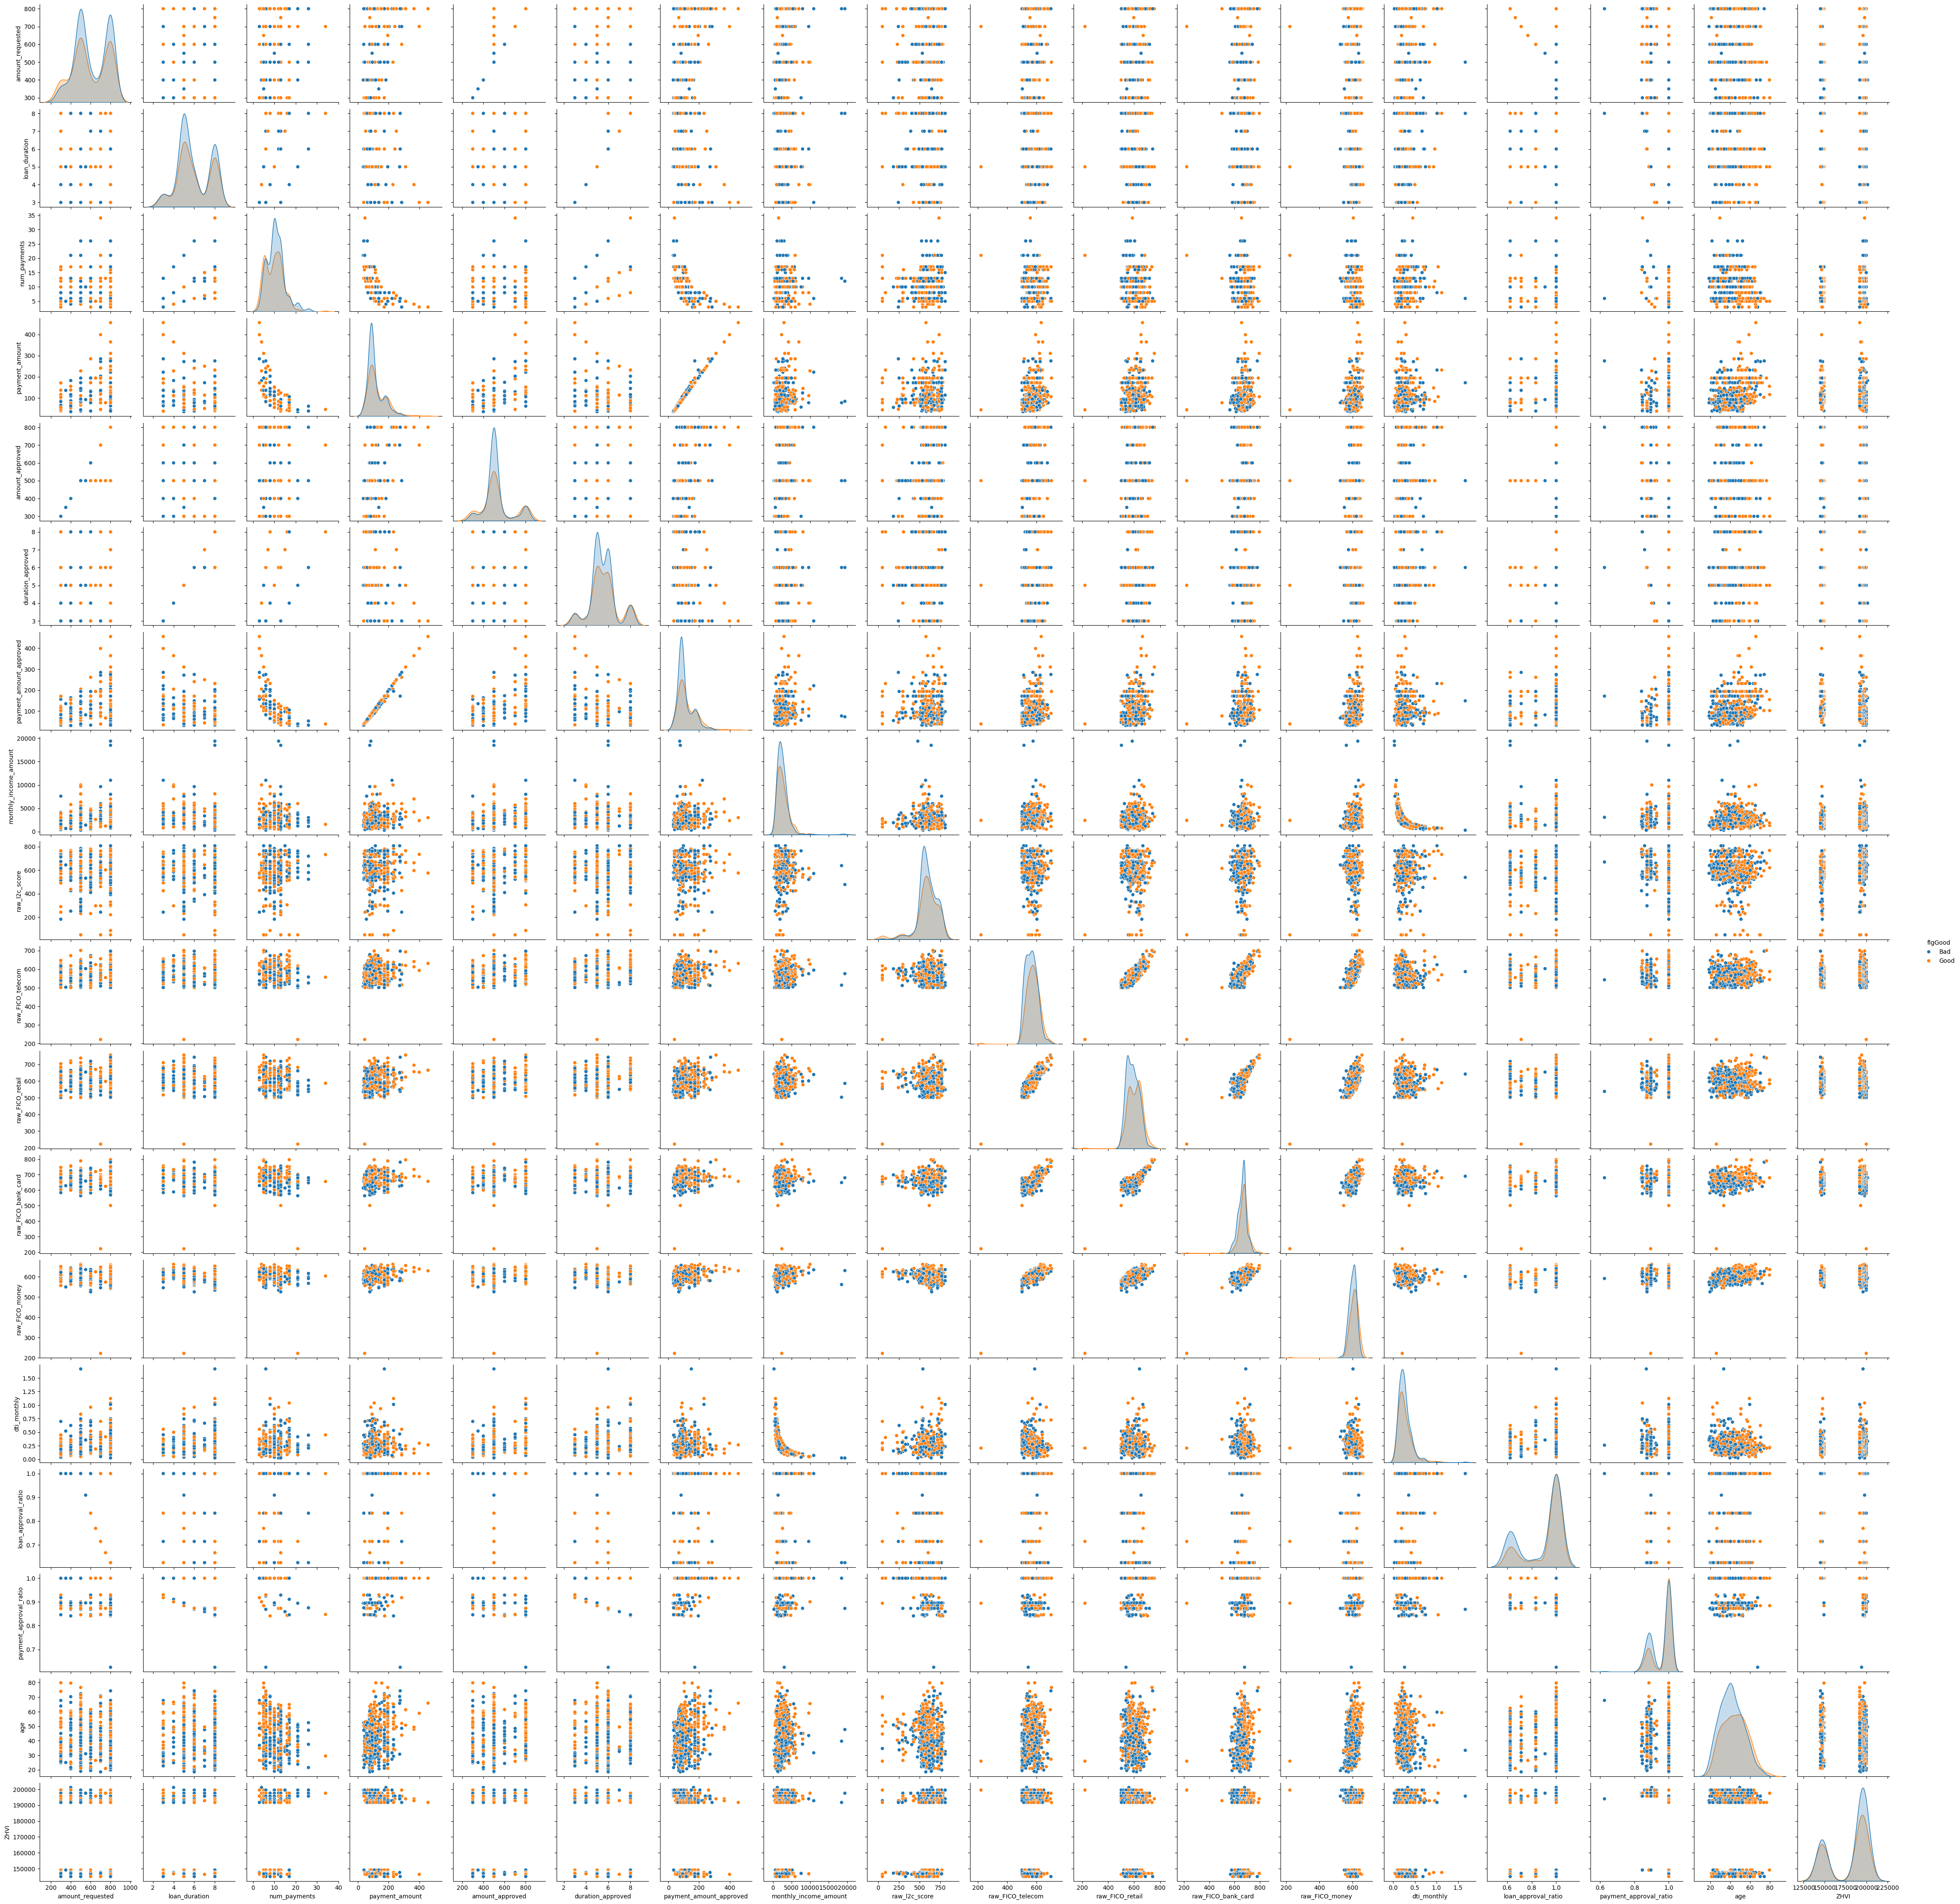

In [ ]:
sns.pairplot(loan_df[numerical_cols.to_list()+[y_col]], hue="flgGood")

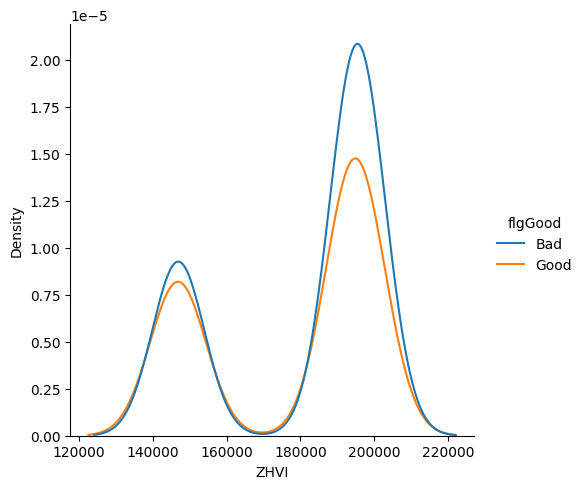

In [ ]:
sns.displot(loan_df, x="ZHVI", hue="flgGood",
            kind="kde")

## Modeling and Preliminary Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


X_df = loan_df[numerical_cols.to_list() + categorical_cols]
y = loan_df[y_col]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y,
                                                    test_size=0.30,
                                                    random_state=3)

y_binarized_train = LabelEncoder().fit_transform(y_train)
y_binarized_test = LabelEncoder().fit_transform(y_test)
new_X_train = preprocessor.fit_transform(X_train, y_binarized_train)
new_X_test = preprocessor.transform(X_test)



In [ ]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

flgGood
Bad     0.559719
Good    0.440281
Name: proportion, dtype: float64
flgGood
Bad     0.532609
Good    0.467391
Name: proportion, dtype: float64


Lasso feature selection

In [ ]:
selected_lasso_indices = np.where(Lasso(alpha=0.01).fit(new_X_train, y_binarized_train).coef_ != 0)[0]
lasso_col_names = preprocessor.get_feature_names_out()[selected_lasso_indices]
lasso_col_names

array(['num__amount_requested', 'num__duration_approved',
       'num__payment_amount_approved', 'num__raw_FICO_retail',
       'num__raw_FICO_bank_card', 'num__loan_approval_ratio',
       'num__payment_approval_ratio', 'num__age', 'num__ZHVI',
       'cat__bank_account_duration_1-2 years',
       'cat__bank_account_duration_3+ years',
       'cat__residence_duration_6 months or less',
       'cat__residence_duration_7-12 months',
       'cat__residence_rent_or_own_False',
       'cat__payment_frequency_Bi-weekly',
       'cat__payment_frequency_Semi-monthly'], dtype=object)

In [ ]:
loan_df[[col.split("__")[-1] for col in lasso_col_names if col.split("__")[0] != "cat"]].corr()

amount_requested  duration_approved  \
amount_requested                 1.000000           0.386952   
duration_approved                0.386952           1.000000   
payment_amount_approved          0.210395          -0.076238   
raw_FICO_retail                  0.001015           0.031637   
raw_FICO_bank_card              -0.023331           0.030819   
loan_approval_ratio             -0.621552          -0.029520   
payment_approval_ratio          -0.050730          -0.088767   
age                              0.013557           0.048070   
ZHVI                             0.109733           0.011487   

                         payment_amount_approved  raw_FICO_retail  \
amount_requested                        0.210395         0.001015   
duration_approved                      -0.076238         0.031637   
payment_amount_approved                 1.000000         0.166497   
raw_FICO_retail                         0.166497         1.000000   
raw_FICO_bank_card                      0.175684         0.653572   
loan_approval_ratio                     0.112886         0.165890   
payment_approval_ratio                  0.241827         0.126690   
age                                     0.281254         0.026840   
ZHVI                                   -0.157196         0.015822   

                         raw_FICO_bank_card  loan_approval_ratio  \
amount_requested                  -0.023331            -0.621552   
duration_approved                  0.030819            -0.029520   
payment_amount_approved            0.175684             0.112886   
raw_FICO_retail                    0.653572             0.165890   
raw_FICO_bank_card                 1.000000             0.178169   
loan_approval_ratio                0.178169             1.000000   
payment_approval_ratio             0.023750             0.013244   
age                                0.170219             0.075121   
ZHVI                               0.029674            -0.033315   

                         payment_approval_ratio       age      ZHVI  
amount_requested                      -0.050730  0.013557  0.109733  
duration_approved                     -0.088767  0.048070  0.011487  
payment_amount_approved                0.241827  0.281254 -0.157196  
raw_FICO_retail                        0.126690  0.026840  0.015822  
raw_FICO_bank_card                     0.023750  0.170219  0.029674  
loan_approval_ratio                    0.013244  0.075121 -0.033315  
payment_approval_ratio                 1.000000  0.075261 -0.484226  
age                                    0.075261  1.000000 -0.110865  
ZHVI                                  -0.484226 -0.110865  1.000000

For a general feature selection method, using default random forest for feature importance scores and plan on training then tuning different models afterwards.

In [ ]:
feature_selector = RandomForestClassifier(n_estimators=100, random_state=1)\
                        .fit(new_X_train, y_binarized_train)
feat_imp_df = pd.DataFrame({"Feature": preprocessor.get_feature_names_out(),
                            "Importance": feature_selector.feature_importances_})
feat_imp_df = feat_imp_df.sort_values(by=["Importance"],
                                      ascending=False).reset_index(drop=True)
top_20 = feat_imp_df.loc[0:19,"Feature"]
top_20 = pd.DataFrame({"Feature": top_20})
top_20

Feature
0                  num__raw_FICO_retail
1               num__raw_FICO_bank_card
2                   num__raw_FICO_money
3                    num__raw_l2c_score
4                              num__age
5                 num__raw_FICO_telecom
6                      num__dti_monthly
7            num__monthly_income_amount
8                             num__ZHVI
9          num__payment_amount_approved
10                  num__payment_amount
11          num__payment_approval_ratio
12                num__amount_requested
13                    num__num_payments
14             num__loan_approval_ratio
15     cat__payment_frequency_Bi-weekly
16                   num__loan_duration
17  cat__bank_account_duration_3+ years
18               num__duration_approved
19                 num__amount_approved

In [ ]:
features_to_remove = {"num__loan_approval_ratio",
                      "num__payment_approval_ratio"}
remove_idx_rf = [np.where(lasso_col_names == val)[0][0] \
                 for val in features_to_remove]
lasso_col_names = np.delete(lasso_col_names, remove_idx_rf)
selected_lasso_indices = np.delete(selected_lasso_indices, remove_idx_rf)

In [ ]:
selected_rf_feature_indices = [i for i in range(len(preprocessor.get_feature_names_out())) \
                               if preprocessor.get_feature_names_out()[i] in set(top_20["Feature"])]

In [ ]:
corr_rf_mat = pd.DataFrame(\
    new_X_train[:,selected_rf_feature_indices]).corr().values
arr1, arr2 = np.where(abs(corr_rf_mat) > 0.6)
for i,j in zip(arr1, arr2):
  if i < j:
    print(f"{top_20['Feature'].values[i]} and {top_20['Feature'].values[j]}")
    print(corr_rf_mat[i,j])

num__raw_FICO_retail and num__age
0.7016127805331518
num__raw_FICO_retail and num__loan_approval_ratio
-0.6319601123244138
num__raw_FICO_bank_card and num__raw_FICO_telecom
0.8721268080031861
num__raw_FICO_money and num__raw_l2c_score
-0.6620776967980438
num__raw_FICO_money and num__dti_monthly
-0.6677401779874553
num__raw_l2c_score and num__dti_monthly
0.9900607329691637
num__payment_amount_approved and num__payment_amount
0.8928060509418713
num__payment_amount_approved and num__payment_approval_ratio
0.7294058092068677
num__payment_amount_approved and num__amount_requested
0.7804063015640823
num__payment_amount and num__payment_approval_ratio
0.6671667179904119
num__payment_amount and num__amount_requested
0.7035542349062943
num__payment_approval_ratio and num__amount_requested
0.7035399667443768


In [ ]:
features_to_remove = {"num__raw_l2c_score",
                     "num__monthly_income_amount",
                     "num__payment_approval_ratio",
                     "num__loan_approval_ratio"}

selected_col_names = top_20["Feature"].values
selected_col_indices = selected_rf_feature_indices

remove_idx_rf = [np.where(selected_col_names == val)[0][0] \
                 for val in features_to_remove]
top_20 = top_20.loc[~top_20["Feature"].isin(features_to_remove)]
selected_rf_feature_indices = np.delete(selected_col_indices, remove_idx_rf)


Sequential Feature Selection (forward) for each model. To obtain a common feature set to be used during model comparison, determine the largest proportion of features taken from the top 20 features ranked by importance by Random Forest.

In [ ]:
clf1 = LogisticRegression(random_state=1, penalty="elasticnet",
                          solver="saga", l1_ratio=0.5,
                          max_iter=1000)
clf2 = DecisionTreeClassifier(random_state=1)
clf3 = RandomForestClassifier(random_state=1)
clf4 = xgb.XGBClassifier(random_state=1)

clf_dict = dict()

for clf in [clf1,clf2,clf3,clf4]:
  model_name = clf.__class__.__name__
  print(model_name)
  sfs = SequentialFeatureSelector(estimator = clf,
                            scoring= "recall",
                            direction = "forward",
                            cv = 5).fit(new_X_train,
                                        y_binarized_train)

  col_names = preprocessor.get_feature_names_out()[sfs.get_support()]
  feature_matrix = sfs.transform(new_X_train)
  feature_matrix_test = sfs.transform(new_X_test)
  clf_dict[model_name] = {"col_names": col_names,
                          "col_indices": sfs.get_support(),
                          "feature_matrix": feature_matrix,
                          "feature_matrix_test": feature_matrix_test,
                          "clf": clf}

LogisticRegression
DecisionTreeClassifier
RandomForestClassifier
XGBClassifier


In [ ]:
feature_to_clf = defaultdict(list)
for clf_name in clf_dict:
  selected_col_indices = clf_dict[clf_name]["col_indices"]
  selected_col_names = clf_dict[clf_name]["col_names"]
  for col in selected_col_names:
    feature_to_clf[col].append(clf_name)

In [ ]:
# Out of the top 20 chosen features, most features selected from Logistic
# Regression Model
models_df = pd.DataFrame({"Feature": feature_to_clf.keys(),
              "Models": feature_to_clf.values()})
top_20.merge(models_df, on="Feature", how="left")["Models"]\
      .dropna()\
      .explode()\
      .value_counts()

Models
LogisticRegression        5
DecisionTreeClassifier    2
RandomForestClassifier    1
XGBClassifier             1
Name: count, dtype: int64

In [ ]:
corr_mat = pd.DataFrame(\
    new_X_train[:,np.where(clf_dict["LogisticRegression"]["col_indices"])[0]]).corr().values
arr1, arr2 = np.where(abs(corr_mat) > 0.5)
clf_dict[clf_name]["correlated_indices"] = zip(arr1, arr2)
for i,j in clf_dict[clf_name]["correlated_indices"]:
  if i < j:
    print(f"{selected_col_names[i]} and {selected_col_names[j]}")

cat__how_use_money_Bills (General) and cat__payment_frequency_Weekly
cat__how_use_money_Bills (Home / Utilities) and cat__how_use_money_Bills (Medical)
cat__residence_duration_7-12 months and cat__email_duration_1 year or more
cat__residence_duration_7-12 months and cat__email_duration_3 months or less
cat__payment_frequency_Bi-weekly and cat__payment_frequency_Weekly
cat__region_Midwest and cat__region_West


In [ ]:
# use common feature set
for clf_name in clf_dict:
  if clf_name != "LogisticRegression":
    clf_dict[clf_name]["col_indices"] = clf_dict["LogisticRegression"]["col_indices"]
    clf_dict[clf_name]["feature_matrix"] = clf_dict["LogisticRegression"]["feature_matrix"]
    clf_dict[clf_name]["feature_matrix_test"] = clf_dict["LogisticRegression"]["feature_matrix_test"]
    clf_dict[clf_name]["col_names"] = clf_dict["LogisticRegression"]["col_names"]


In [ ]:
features_to_remove = {"cat__email_provider_bing.com"}
selected_col_names = clf_dict["LogisticRegression"]["col_names"]
selected_col_indices = clf_dict["LogisticRegression"]["col_indices"]

index_to_remove = [np.where(selected_col_names == val)[0][0] \
                    for val in features_to_remove]
# removing the multicollinear feature at index "index_to_remove"
selected_col_names = np.delete(selected_col_names, index_to_remove)
selected_col_indices = np.delete(selected_col_indices, index_to_remove)

clf_dict["LogisticRegression"]["col_names"] = selected_col_names
clf_dict["LogisticRegression"]["col_indices"] = selected_col_indices
clf_dict["LogisticRegression"]["feature_matrix"] = np.delete(
    clf_dict["LogisticRegression"]["feature_matrix"],
    index_to_remove,
    axis=1
)


In [ ]:
# # without hyperparameter tuning
# for clf_name in clf_dict:
#   model = clf_dict[clf_name]["clf"]
#   model = model.fit(clf_dict[clf_name]["feature_matrix"],
#                     y_binarized_train)
#   X_test_selected = clf_dict[clf_name]["feature_matrix_test"]
#   predicted_y = model.predict(X_test_selected)
#   print(f"Test Performance for {clf_name}:")
#   print(f"Accuracy: {accuracy_score(y_binarized_test, predicted_y)}")
#   print(f"Precision: {precision_score(y_binarized_test, predicted_y)}")
#   print(f"Recall: {recall_score(y_binarized_test, predicted_y)}")
#   print(f"F1 Score: {f1_score(y_binarized_test, predicted_y)}")
#   print(f"ROC AUC Score: {roc_auc_score(y_binarized_test, predicted_y)}")
#   print("\n")

In [ ]:
print("Lasso Features:", lasso_col_names)
print("RF Features:", top_20["Feature"].values)
print("SFS Features:", selected_col_names)

Lasso Features: ['num__amount_requested' 'num__duration_approved'
 'num__payment_amount_approved' 'num__raw_FICO_retail'
 'num__raw_FICO_bank_card' 'num__age' 'num__ZHVI'
 'cat__bank_account_duration_1-2 years'
 'cat__bank_account_duration_3+ years'
 'cat__residence_duration_6 months or less'
 'cat__residence_duration_7-12 months' 'cat__residence_rent_or_own_False'
 'cat__payment_frequency_Bi-weekly' 'cat__payment_frequency_Semi-monthly']
RF Features: ['num__raw_FICO_retail' 'num__raw_FICO_bank_card' 'num__raw_FICO_money'
 'num__age' 'num__raw_FICO_telecom' 'num__dti_monthly' 'num__ZHVI'
 'num__payment_amount_approved' 'num__payment_amount'
 'num__amount_requested' 'num__num_payments'
 'cat__payment_frequency_Bi-weekly' 'num__loan_duration'
 'cat__bank_account_duration_3+ years' 'num__duration_approved'
 'num__amount_approved']
SFS Features: ['num__raw_FICO_retail' 'num__raw_FICO_bank_card' 'num__raw_FICO_money'
 'num__raw_l2c_score' 'num__age' 'num__raw_FICO_telecom'
 'num__dti_monthl

Further Model Selection and Test Evaluation

In [ ]:
# Logistic Regression:

param_grid_lr = {
    'C': [0.1, 0.5, 0.75, 1, 2, 3],
    "penalty": ["elasticnet"],
    'l1_ratio': np.arange(0,1,0.05),
    'solver': ['saga'],
    "max_iter":[5000]
}

clf_dict["LogisticRegression"]["param_grid"] = param_grid_lr

# Decision Tree Classifier:
# - max_depth
# - min_samples_split
# - min_samples_leaf
# - min_weight_fraction_leaf
# - max_features
# - max_leaf_nodes

param_grid_dt = {
    'max_depth': list(range(3, 12, 2))+[None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20]
}
clf_dict["DecisionTreeClassifier"]["param_grid"] = param_grid_dt

# Random Forest Classifier:

param_grid_rf = {
    'n_estimators': [10, 15, 20, 30, 40, 50],
    'max_depth': list(range(3, 12, 2))+[None]
}
clf_dict["RandomForestClassifier"]["param_grid"] = param_grid_rf

# XGBoost Classifier:
# past grid searches revealed max_depth None was preferred over max depths from
# 4 to 20

# subsampling 0.5 would reduce overfitting.

param_grid_xgb = {'n_estimators': [75, 100, 125],
    'eta': [0.25, 0.4, 0.55],
    'gamma': [0.01, 0.1, 0.2],
    'max_depth': [None],
    'lambda': [0.01, 0.1, 0.2],
    'alpha': [0.01, 0.1, 0.2],
    'subsample': [0.35, 0.5, 0.65]
}

clf_dict["XGBClassifier"]["param_grid"] = param_grid_xgb

averages = {"sfs": 0,
            "lasso": 0,
            "rf": 0}

for clf_name in clf_dict:
  param_grid = clf_dict[clf_name]["param_grid"]
  print(clf_name, param_grid)
  X_train_selected = clf_dict[clf_name]["feature_matrix"]
  model = clf_dict[clf_name]["clf"]
  grid_search_model = GridSearchCV(model, param_grid,
                                   cv=5, scoring='f1_macro')
  grid_search_model.fit(X_train_selected, y_binarized_train)

  X_train_lasso = new_X_train[:, selected_lasso_indices]
  grid_search_lasso = GridSearchCV(model, param_grid,
                                   cv=5, scoring='f1_macro')
  grid_search_lasso.fit(X_train_lasso, y_binarized_train)

  X_train_rf_imp = new_X_train[:, selected_rf_feature_indices]
  grid_search_rf_imp = GridSearchCV(model, param_grid,
                                   cv=5, scoring='f1_macro')
  grid_search_rf_imp.fit(X_train_rf_imp, y_binarized_train)

  print(f"Best Parameters for {clf_name}:", grid_search_model.best_params_)
  print(f"Best F1 Macro Score for {clf_name}:", grid_search_model.best_score_)

  print(f"Parameters for {clf_name} on Lasso Selected Features:",
        grid_search_lasso.best_params_)
  print(f"F1 Macro Score for {clf_name} on Lasso Selected Features:",
        grid_search_lasso.best_score_)
  print(f"Parameters for {clf_name} on RF T20 Features:",
        grid_search_rf_imp.best_params_)
  print(f"F1 Macro Score for {clf_name} on RF T20 Features:",
        grid_search_rf_imp.best_score_)
  for name, top_model in zip(["sfs", "lasso", "rf"], [grid_search_model,
                                                  grid_search_lasso,
                                                  grid_search_rf_imp]):

    clf_dict[clf_name][f"{name}_best_params"] = top_model.best_params_
    clf_dict[clf_name][f"{name}_best_score"] = top_model.best_score_
    clf_dict[clf_name][f"{name}_best_model"] = top_model.best_estimator_
    averages[name] += top_model.best_score_
  print("\n")

LogisticRegression {'C': [0.1, 0.5, 0.75, 1, 2, 3], 'penalty': ['elasticnet'], 'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]), 'solver': ['saga'], 'max_iter': [5000]}
Best Parameters for LogisticRegression: {'C': 0.5, 'l1_ratio': 0.30000000000000004, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best F1 Macro Score for LogisticRegression: 0.6102585870956238
Parameters for LogisticRegression on Lasso Selected Features: {'C': 0.1, 'l1_ratio': 0.4, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'}
F1 Macro Score for LogisticRegression on Lasso Selected Features: 0.647176082327201
Parameters for LogisticRegression on RF T20 Features: {'C': 0.1, 'l1_ratio': 0.45, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'}
F1 Macro Score for LogisticRegression on RF T20 Features: 0.6458829664590884


DecisionTreeClassifier {'max_depth': [3, 5, 7, 9, 11, None], 'min_s

In [ ]:
averages = {k:v/len(clf_dict) for k,v in averages.items()}
prepend = max(averages, key=averages.get)

In [ ]:
round(pd.DataFrame(averages.values(),index=averages.keys(),
             columns=["Average F1 Macro Score Across the 4 models"])*100,2).astype(str) + "%"

Average F1 Macro Score Across the 4 models
sfs                                       57.48%
lasso                                     62.83%
rf                                        62.73%

In [ ]:
exec(f"X_test_selected = new_X_test[:, selected_{prepend}_indices]")

Test Performance for LogisticRegression:
Accuracy: 0.5815217391304348
Precision: 0.5918367346938775
Recall: 0.3372093023255814
F1 Score: 0.42962962962962964
ROC AUC Score: 0.636687233032748




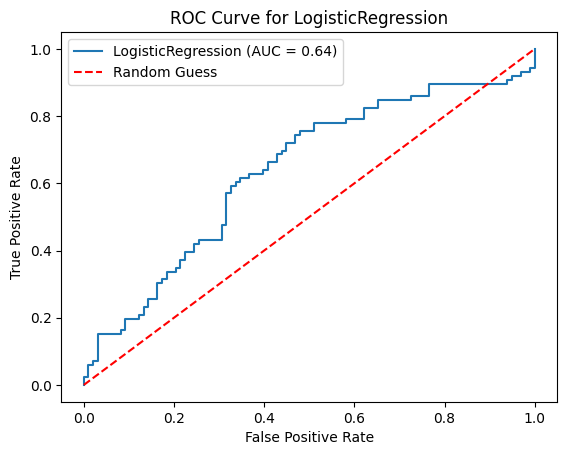

Test Performance for DecisionTreeClassifier:
Accuracy: 0.532608695652174
Precision: 0.5
Recall: 0.46511627906976744
F1 Score: 0.4819277108433735
ROC AUC Score: 0.5364261983863312




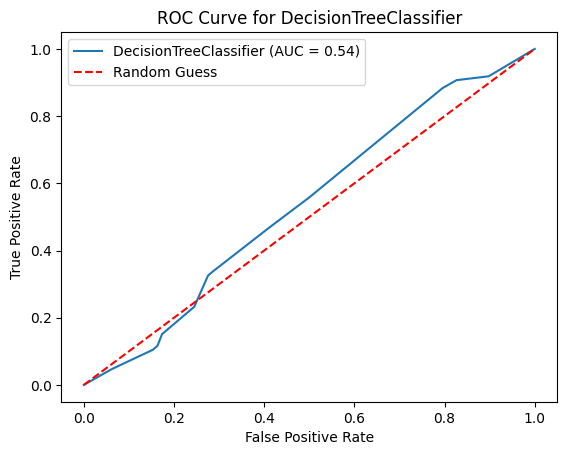

Test Performance for RandomForestClassifier:
Accuracy: 0.5489130434782609
Precision: 0.5333333333333333
Recall: 0.27906976744186046
F1 Score: 0.366412213740458
ROC AUC Score: 0.6122448979591836




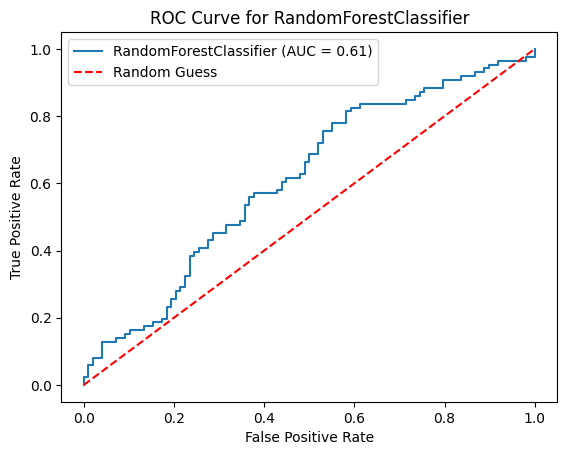

Test Performance for XGBClassifier:
Accuracy: 0.5815217391304348
Precision: 0.5652173913043478
Recall: 0.45348837209302323
F1 Score: 0.5032258064516129
ROC AUC Score: 0.5836497389653535




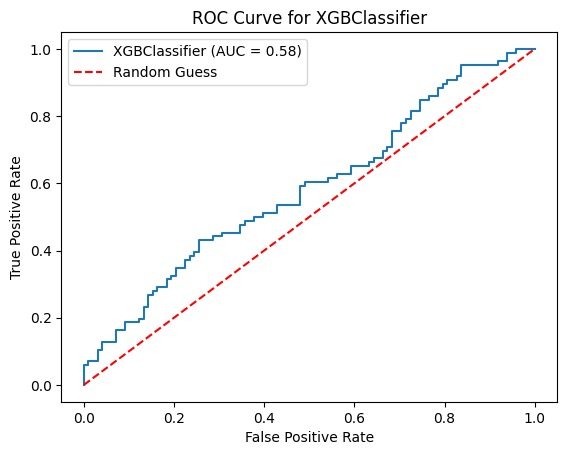

In [ ]:
# Test Performance using top parameters - using random forest features selected
for clf_name in clf_dict:
  model = clf_dict[clf_name][f"{prepend}_best_model"]
  predicted_y = model.predict(X_test_selected)
  predicted_proba_y = model.predict_proba(X_test_selected)[:,1]
  print(f"Test Performance for {clf_name}:")
  print(f"Accuracy: {accuracy_score(y_binarized_test, predicted_y)}")
  print(f"Precision: {precision_score(y_binarized_test, predicted_y)}")
  print(f"Recall: {recall_score(y_binarized_test, predicted_y)}")
  print(f"F1 Score: {f1_score(y_binarized_test, predicted_y)}")
  print(f"ROC AUC Score: {roc_auc_score(y_binarized_test, predicted_proba_y)}")
  print("\n")
  fpr, tpr, _ = roc_curve(y_binarized_test, predicted_proba_y)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {clf_name}')
  plt.legend()
  plt.show()

In alignment with Zest AI's economic equity mission, we would like to get most of the 'Good' loans to be predicted as actually 'Good' to improve loan access. 'Good' is encoded as positive cases in the problem 'Good' = 1, 'Bad' = 0. The recall macro score would be of interest in this problem in minimizing false negatives.

### Feature Importance

/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

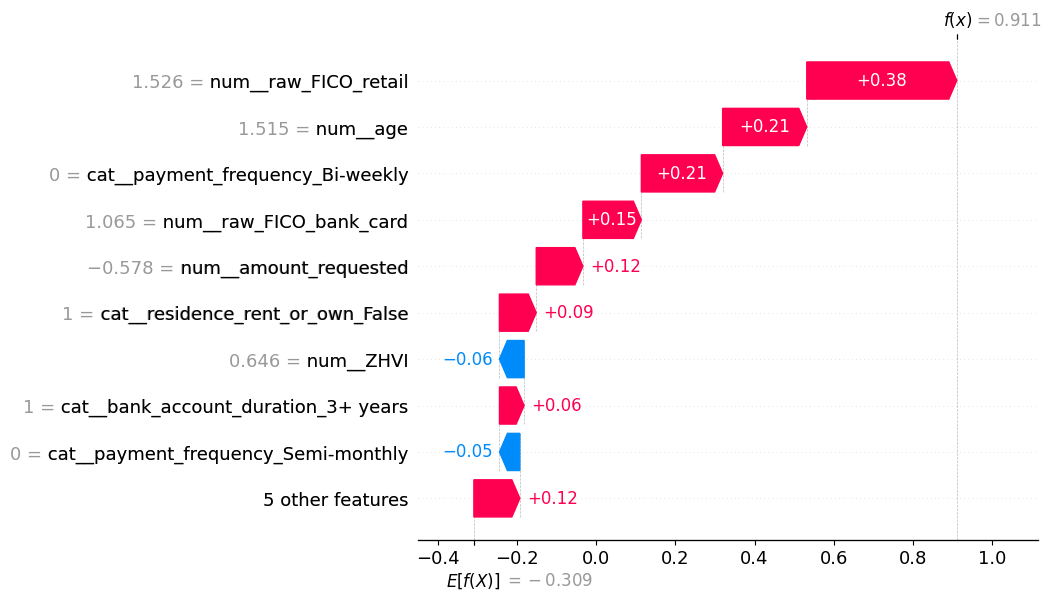

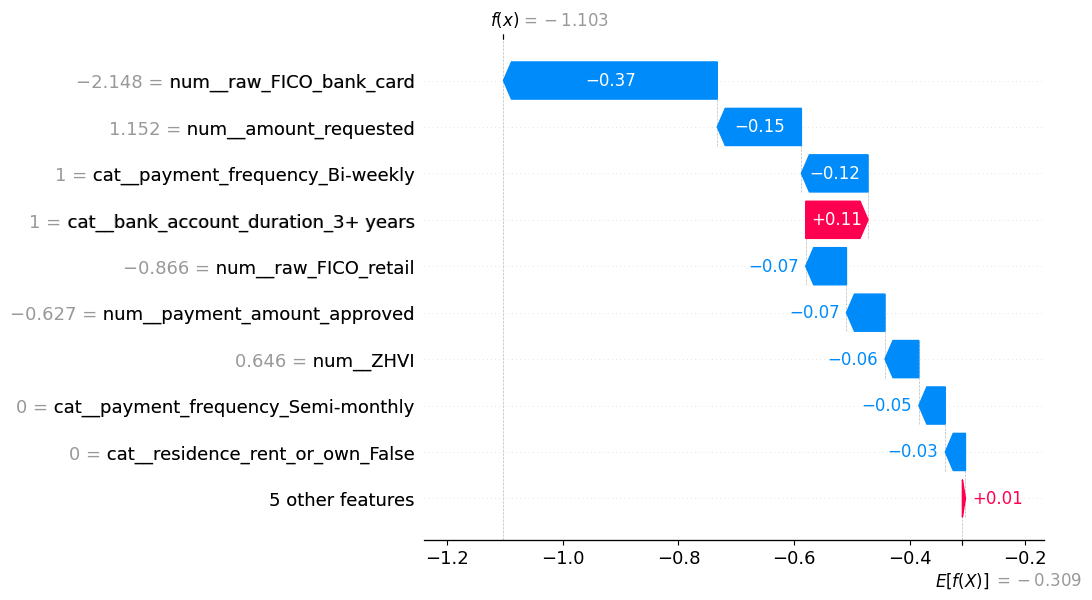

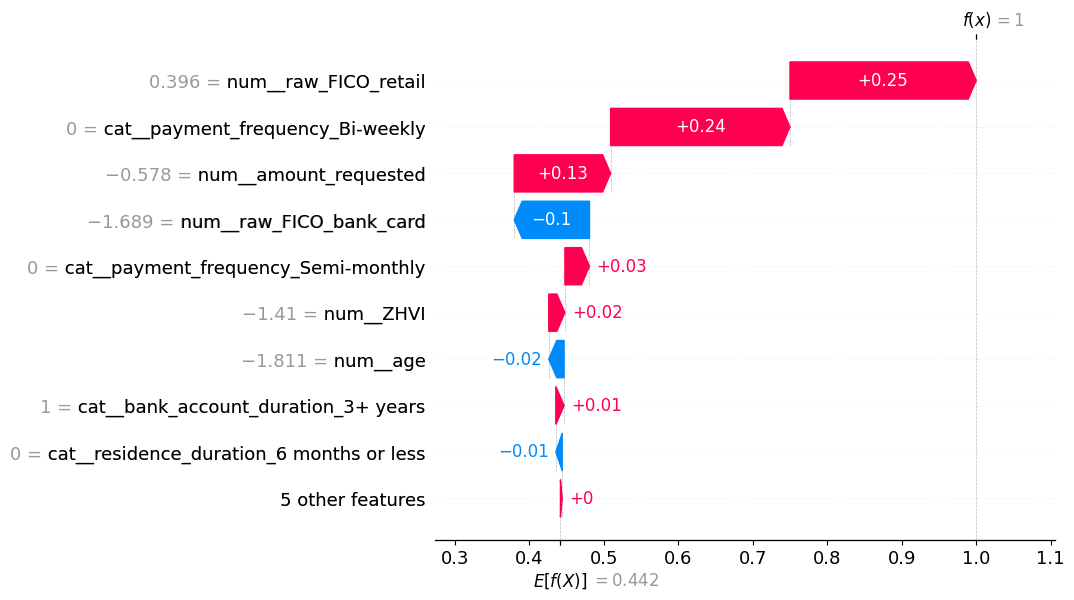

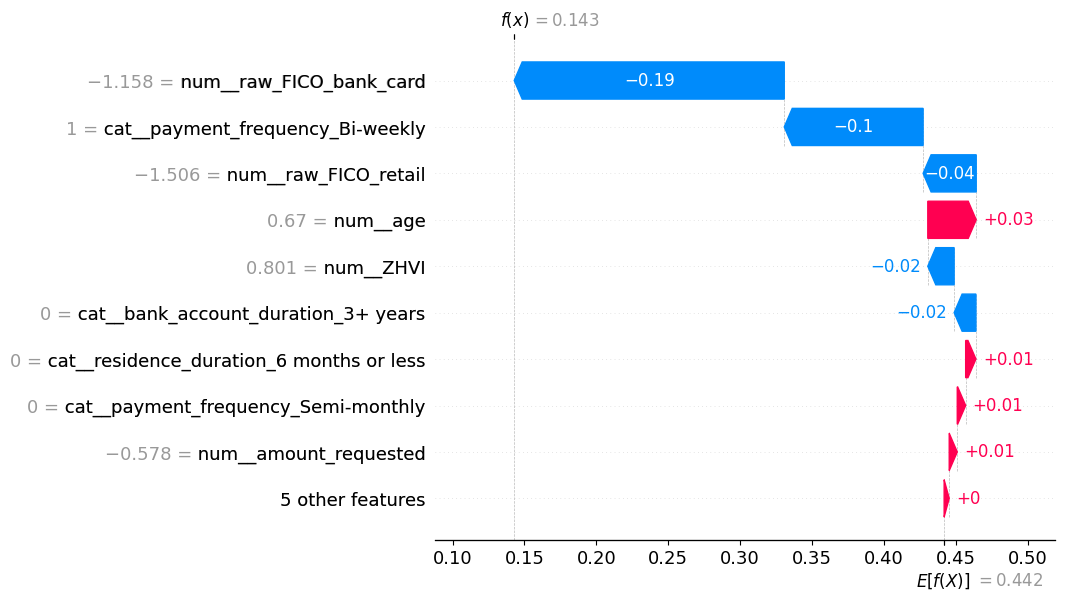

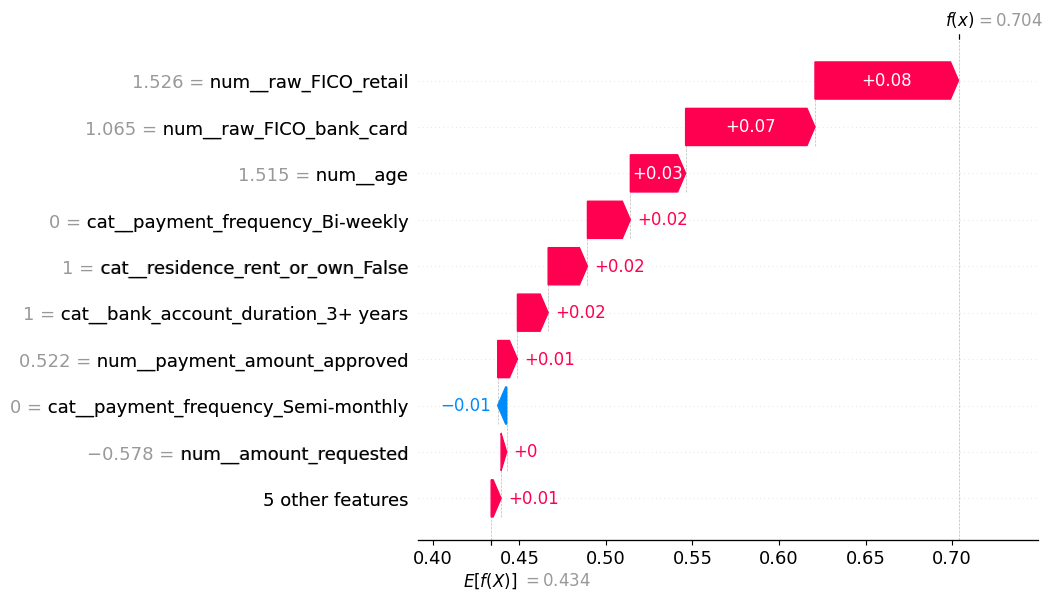

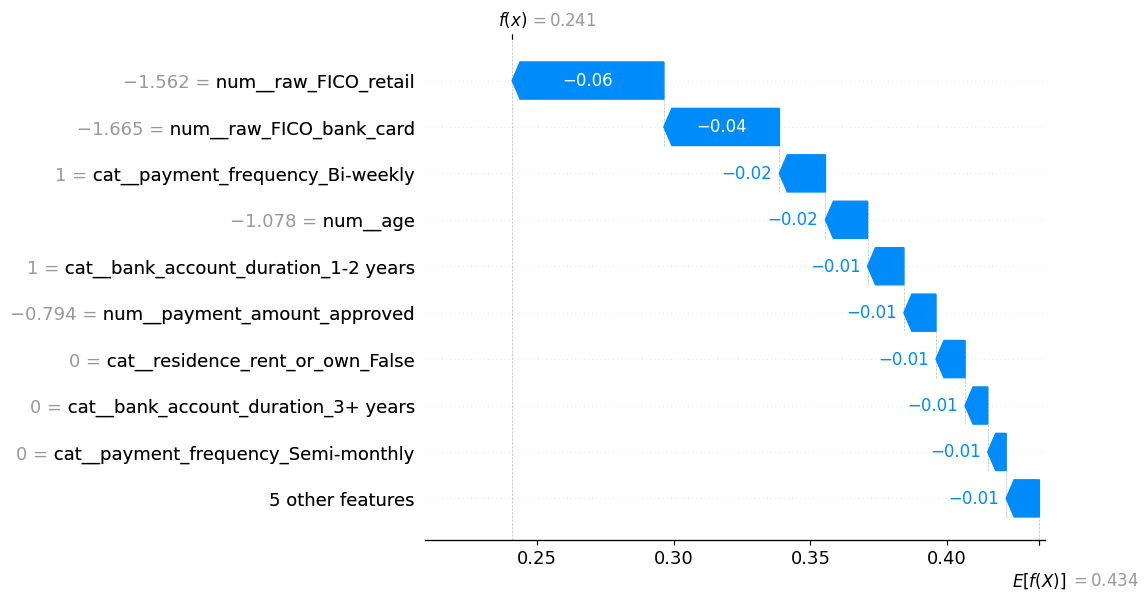

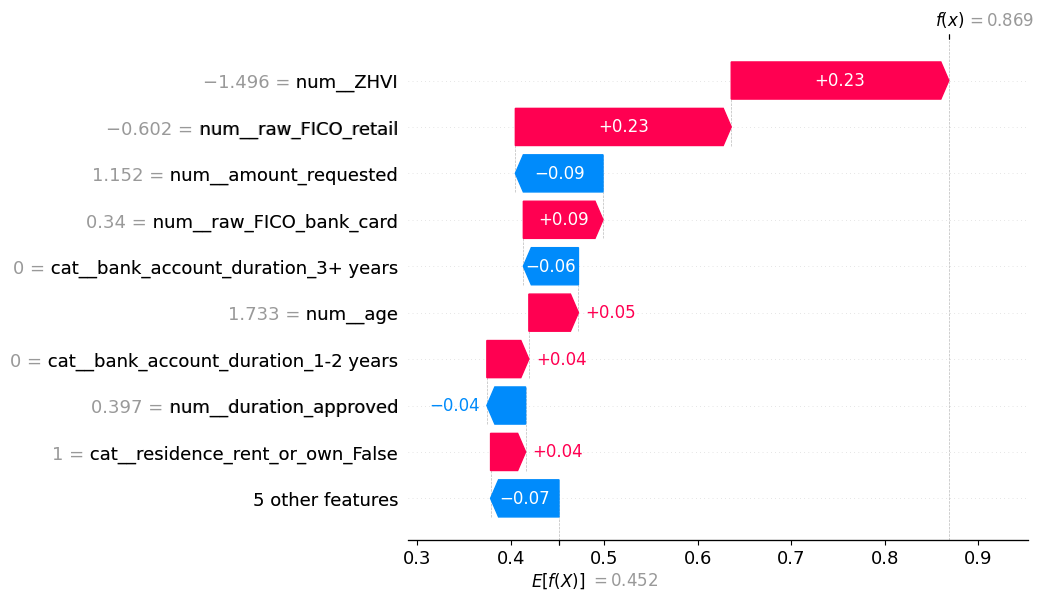

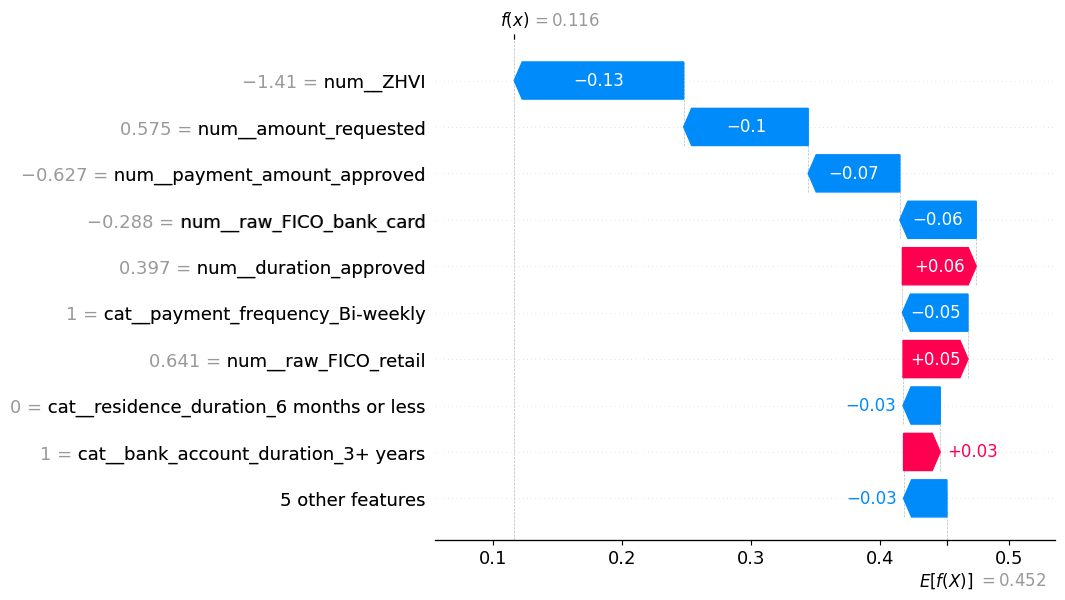

In [ ]:
%matplotlib inline

for clf_name in clf_dict:
  model = clf_dict[clf_name][f"{prepend}_best_model"]
  if clf_name == "LogisticRegression":
    explainer = shap.LinearExplainer(model,
                          masker=shap.maskers.Impute(data=X_test_selected),
                                     data=X_test_selected,
                                    feature_perturbation="interventional",
                                     model_output="probability")
  else:
    explainer = shap.TreeExplainer(model,
                                    data=X_test_selected,
                                    feature_perturbation="interventional",
                                    model_output="probability")
  shap_df = pd.DataFrame(X_test_selected,
        columns=lasso_col_names)

  shap_values = explainer(shap_df)
  if clf_name in {"LogisticRegression", "XGBClassifier"}:
    base_value = explainer.expected_value
    shap_values_positive_class = shap_values
  else:
    base_value = explainer.expected_value[1]
    shap_values_positive_class = shap_values[:, :, 1]
  # 0 is row index
  index_good = np.where(model.predict_proba(X_test_selected)[:,1] > 0.70)[0][0]
  index_bad = np.where(model.predict_proba(X_test_selected)[:,1] < 0.25)[0][0]
  for index in [index_good, index_bad]:
    shap.plots.waterfall(shap_values_positive_class[index])


## Calibration

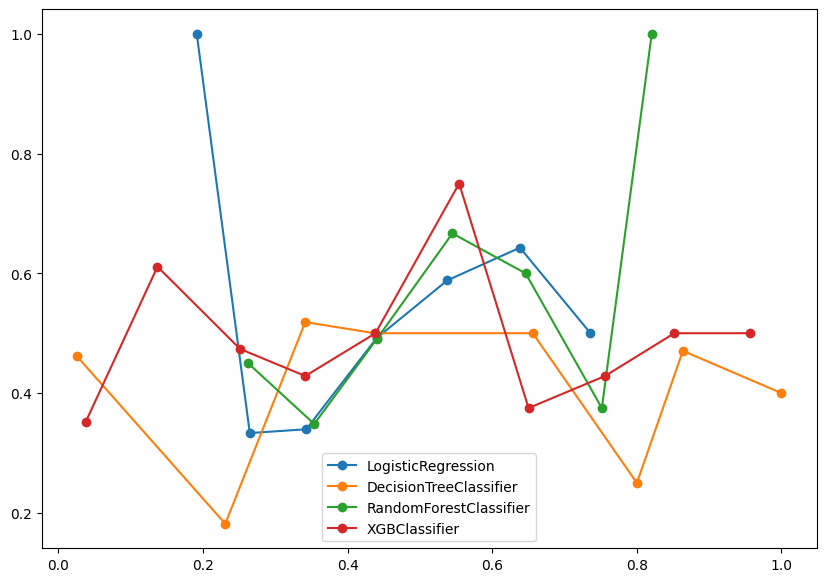

In [199]:
model_names = list(clf_dict.keys())

probabilities = []
for name in model_names:
  X_test_selected = new_X_test[:, selected_rf_feature_indices]
  y_prob = clf_dict[name]["rf_best_model"].predict_proba(X_test_selected)[:,1]
  probabilities.append(y_prob)

plt.figure(figsize=(10, 7))
for i, y_prob in enumerate(probabilities):
    prob_true, prob_pred = calibration_curve(y_binarized_test, y_prob,
                                             n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true,
             marker='o', label=f'{model_names[i]}')
plt.legend()

# Discussion

## Summary

To promote economic equity through broader loan access, recall is the evaluation metric used for model comparison.


## Areas of Improvement

#### Data Integrity
A more thorough data accuracy check could be conducted. For instance, given more time, more work can be done to expand on the routing map below to ensure the zip code for each customer aligns with the location of their routing number.

#### Feature Engineering

Attributes of the bank could be added into the modeling stage, such as the bank type of whether or not the bank is a credit union. Customers at credit unions may show better loan performance.

#### Modeling Decisions

From the loan performance table, the most recent binary performance of a customer's loan in a 6 month period was used as the target variable for modeling. Rerunning the models and evaluation with aggregated loan performance, whether it be the worst or best performance in a 6 month period, can provide additional insights on performance in the worst-case or best-case scenarios of customer borrowing tendencies.

Analyses and modeling was done on 647 customers, which is a fairly small sample. Also, the loan data is taken from a snapshot in 2010/2011, which may not be similar to the distribution of loan applicants present-day.

#### External Data Fusion

Although additional features pulled from selected data sources, such as natural gas usage from zip codes in 2010 "Natural Gas Consumption by Zip Code", the gas usage may not be the most representative at the time the loan was applied for.

Zillow Home Value Index and geographical region variables were considered during the feature engineering phase.


#### Future Analyses
For downstream adhoc analytics tasks, further visualizations can be made on discretized versions of variables such as Age or Income into brackets to answer targeted business questions.

Scalability concerns will be faced when training on models with more parameters that require more data. For larger models, training may be done on a gpu device. For larger hyperparameter search spaces, a bayesian parameter tuning framework such as optuna may be leveraged.



In [ ]:
# Preliminary routing map
routing_map = {124001545: {"State": "FL", "Bank": "JPMC"},
               124000054: {"State": "UT", "Bank": "ZIONS BANCORPORATION"},
               124002971: {"State": "MN", "Bank": "Wells Fargo"},
               324079500: {"State": "UT", "Bank": "UTAH FIRST FEDERAL CREDIT UNION"},
               324377516: {"State": "UT", "Bank": "AMERICA FIRST FEDERAL CREDIT UNION"},
               324079555: {"State": "UT", "Bank": "Mountain America FCU"},
               122238585: {"State": "CA", "Bank": "PACIFIC PREMIER BANK"},
               324377613: {"State": "UT", "Bank": "GOLDENWEST FEDERAL CREDIT UNION"},
               61120000: {"State": "UT", "Bank": "GREEN DOT BANK"},
               21409169: {"State": "FL", "Bank": "JPMC"},
               31101169: {"State": "SD", "Bank": "BANCORP"},
               124303065: {"State": "VA", "Bank": "BOA"},
               211382850: {"State": "MA", "Bank": "I.C. FEDERAL CREDIT UNION"},
               122100024: {"State": "FL", "Bank": "JPMC"},
               324079474: {"State": "VA", "Bank": "CHARTWAY FEDERAL CREDIT UNION"},
               124302150: {"State": "MN", "Bank": "US Bank"},
               324379828: {"State": "VA", "Bank": "CHARTWAY FEDERAL CREDIT UNION"},
               101089742: {"State": "CA", "Bank": "BOFI FEDERAL BANK"},
               114924742: {"State": "SD", "Bank": "BANCORP"},
               324377286: {"State": "UT", "Bank": "GRAND COUNTY CREDIT UNION"},
               51000017: {"State": "VA", "Bank": "BOA"},
               125000105: {"State": "MN", "Bank": "US BANK"},
               124000737: {"State": "NY", "Bank": "KEY BANK"},
               31100209: {"State": "DE", "Bank": "CITIBANK"},
               324078899: {"State": "UT", "Bank": "HEALTH CARE CREDIT UNION"},
               324377202: {"State": "UT", "Bank": "CYPRUS FEDERAL CREDIT UNION"},
               73972181: {"State": "SD", "Bank": "METABANK"},
               324379705: {"State": "UT", "Bank": "JORDAN CREDIT UNION"},
               324379763: {"State": "UT", "Bank": "NEBO CREDIT UNION"},
               324079539: {"State": "UT", "Bank": "UTAH POWER & LIGHT CREDIT UNION"},
               122244171: {"State": "CA", "Bank": "PACIFIC WESTERN BANK"}}